# Imports

In [27]:
import random
import math
import matplotlib.pyplot as plt

# VRPTW

In [28]:
class VRPTW:
    def __init__(self, distance_matrix, time_windows, customer_demand, vehicle_capacity=200, max_num_vehicles=25, num_ants=25, num_iterations=100, evaporation_rate=0.95, penalty_factor=10, reward_factor=1, pheromone_multiplier=1, unused_penalty=1):
        self.distance_matrix = distance_matrix
        self.time_windows = time_windows
        self.customer_demand = customer_demand
        self.vehicle_capacity = vehicle_capacity
        self.max_num_vehicles = max_num_vehicles
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.evaporation_rate = evaporation_rate
        self.unused_penalty = unused_penalty

        # Initialize pheromone levels for all edges
        self.pheromones = [[1 for _ in range(len(distance_matrix))] for _ in range(len(distance_matrix))]
        
        self.best_solution = None
        self.best_cost = float('inf')
        self.best_missed_time_windows = 0
        self.total_missed_time_windows = 0
        self.penalty_factor = penalty_factor
        self.reward_factor = reward_factor
        self.pheromone_multiplier = pheromone_multiplier

    def construct_solution(self):
        solutions = []
        best_cost_this_iteration = float('inf')
        best_missed_time_windows_this_iteration = 0

        for _ in range(self.num_ants):
            routes = [[] for _ in range(self.max_num_vehicles)]
            capacities = [0 for _ in range(self.max_num_vehicles)]
            current_time = [0 for _ in range(self.max_num_vehicles)]
            visited_customers = set()
            unvisited_customers = set(range(1, len(self.distance_matrix)))

            for vehicle in range(self.max_num_vehicles):
                while unvisited_customers:
                    next_customer = self.select_next_customer(0, capacities[vehicle], current_time[vehicle], visited_customers)
                    if next_customer is None:
                        break

                    routes[vehicle].append(next_customer)
                    visited_customers.add(next_customer)
                    capacities[vehicle] += self.customer_demand[next_customer]
                    current_time[vehicle] = max(current_time[vehicle] + self.distance_matrix[0][next_customer], self.time_windows[next_customer][0])
                    unvisited_customers.remove(next_customer)

                if routes[vehicle]:
                    routes[vehicle].append(0)  # Return to depot
                if not unvisited_customers:
                    break

            solutions.append(routes)
            total_cost = sum(self.calculate_route_cost(route, current_time[vehicle])[0] for vehicle, route in enumerate(routes) if route)
            total_cost += sum(1 for route in routes if not route) * self.unused_penalty
            missed_time_windows = sum(self.calculate_route_cost(route, current_time[vehicle])[1] for vehicle, route in enumerate(routes) if route)
            unvisited_count = len(unvisited_customers)
            total_cost += unvisited_count * self.penalty_factor

            if unvisited_count == 0:
                total_cost *= self.reward_factor

            if total_cost < best_cost_this_iteration:
                best_cost_this_iteration = total_cost
                self.best_cost = best_cost_this_iteration
                self.best_solution = [route for route in routes if route]  # Filter out unused vehicles
                best_missed_time_windows_this_iteration = missed_time_windows

        return solutions, best_cost_this_iteration, current_time, best_missed_time_windows_this_iteration

    def select_next_customer(self, current_location, current_capacity, current_time, visited_customers):
        probabilities = []
        for customer in range(1, len(self.distance_matrix)):
            if current_capacity + self.customer_demand[customer] <= self.vehicle_capacity and customer not in visited_customers:
                pheromone = self.pheromones[current_location][customer]
                distance = self.distance_matrix[current_location][customer]
                heuristic = 1 / (distance + 1e-6)
                probability = pheromone * heuristic
                probabilities.append((customer, probability))

        if not probabilities:
            return None

        total = sum(prob for _, prob in probabilities)
        if total <= 0:
            total = 1e-6
        probabilities = [(customer, prob / total) for customer, prob in probabilities]

        return random.choices([customer for customer, _ in probabilities], weights=[prob for _, prob in probabilities])[0]

    def update_pheromones(self, solutions, current_times):
        min_pheromone = 1e-6
        for solution, current_time in zip(solutions, current_times):
            total_cost = 0
            iteration_missed_time_windows = 0
            for route_index, route in enumerate(solution):
                if not route:
                    continue
                route_cost, missed_time_windows = self.calculate_route_cost(route, current_time)
                iteration_missed_time_windows += missed_time_windows
                total_cost += route_cost
                for i in range(len(route) - 1):
                    pheromone_increase = 1 / route_cost * self.pheromone_multiplier
                    self.pheromones[route[i]][route[i + 1]] += pheromone_increase

            self.total_missed_time_windows += iteration_missed_time_windows
        for i in range(len(self.pheromones)):
            for j in range(len(self.pheromones[i])):
                self.pheromones[i][j] *= self.evaporation_rate
                self.pheromones[i][j] = max(self.pheromones[i][j], min_pheromone)

    def calculate_route_cost(self, route, current_time):
        cost = 0
        missed_time_windows = 0
        for i in range(len(route) - 1):
            cost += self.distance_matrix[route[i]][route[i + 1]]
        for i in range(len(route)):
            if current_time < self.time_windows[route[i]][0]:
                cost += self.time_windows[route[i]][0] - current_time
                missed_time_windows += 1
            elif current_time > self.time_windows[route[i]][1]:
                cost += current_time - self.time_windows[route[i]][1]
                missed_time_windows += 1
        return cost, missed_time_windows
    
    def visualize_routes(self, highlight_vehicle=None):
        """Visualize all vehicle routes on a map with consistent dimensions.
        
        Args:
            highlight_vehicle (int): Index of the vehicle route to highlight. If None, no route is highlighted.
        """
        # Initialize the plot
        plt.figure(figsize=(10, 8))
        plt.title("Vehicle Routes for VRPTW", fontsize=14)
        plt.xlabel("X Coordinate", fontsize=12)
        plt.ylabel("Y Coordinate", fontsize=12)

        # Set consistent axis limits based on the coordinate ranges
        plt.xlim(0, 100)  # Adjust these values based on your coordinate range
        plt.ylim(0, 100)  # Adjust these values based on your coordinate range

        # Plot all routes
        for vehicle_index, route in enumerate(self.best_solution):
            if not route:  # Skip empty routes
                continue

            # Collect x and y coordinates for the current route
            x_coords = [self.x_coords[customer] for customer in route]
            y_coords = [self.y_coords[customer] for customer in route]

            if vehicle_index == highlight_vehicle:
                plt.plot(x_coords, y_coords, '-o', label=f"Vehicle {vehicle_index + 1} (Highlighted)", linewidth=3, markersize=8, color='red')
            else:
                plt.plot(x_coords, y_coords, '-o', label=f"Vehicle {vehicle_index + 1}", alpha=0.6)

        # Plot the depot
        plt.scatter(self.x_coords[0], self.y_coords[0], c='black', marker='x', s=100, label="Depot")

        plt.legend()
        plt.grid(True)
        plt.show()

    def run(self):
        for _ in range(self.num_iterations):
            solutions, best_cost_this_iteration, current_times, best_missed_time_windows_this_iteration = self.construct_solution()
            self.update_pheromones(solutions, current_times)

        print("Best Cost Found:", self.best_cost)
        print("Missed Time Windows By Best Solution:", self.best_missed_time_windows)
        print("Best Solution (Routes):")
        for vehicle_index, route in enumerate(self.best_solution):
            print(f"  Vehicle {vehicle_index + 1}: {route}")
        print("Total Vehicles Used:", len(self.best_solution))
        print("Total Missed Time Windows Across All Iterations:", self.total_missed_time_windows)

# c101 constraints

In [29]:
# Handle data from c101
x_coords = [
    40, 45, 45, 42, 42, 42, 40, 40, 38, 38, 35, 35, 25, 22, 22, 20,
    20, 18, 15, 15, 30, 30, 28, 28, 25, 25, 25, 23, 23, 20, 20, 10,
    10, 8, 8, 5, 5, 2, 0, 0, 35, 35, 33, 33, 32, 30, 30, 30, 28,
    28, 26, 25, 25, 44, 42, 42, 40, 40, 38, 38, 35, 50, 50, 50, 48,
    48, 47, 47, 45, 45, 95, 95, 53, 92, 53, 45, 90, 88, 88, 87, 85,
    85, 75, 72, 70, 68, 66, 65, 65, 63, 60, 60, 67, 65, 65, 62, 60,
    60, 58, 55, 55
]

y_coords = [
    50, 68, 70, 66, 68, 65, 69, 66, 68, 70, 66, 69, 85, 75, 85, 80,
    85, 75, 75, 80, 50, 52, 52, 55, 50, 52, 55, 52, 55, 50, 55, 35,
    40, 40, 45, 35, 45, 40, 40, 45, 30, 32, 32, 35, 30, 30, 32, 35,
    30, 35, 32, 30, 35, 5, 10, 15, 5, 15, 5, 15, 5, 30, 35, 40, 30,
    40, 35, 40, 30, 35, 30, 35, 30, 30, 35, 65, 35, 30, 35, 30, 25,
    35, 55, 55, 58, 60, 55, 55, 60, 58, 55, 60, 85, 85, 82, 80, 80,
    85, 75, 80, 85
]

# Combine x and y coordinates into a list of tuples
coordinates = list(zip(x_coords, y_coords))

# Initialize the distance matrix
num_locations = len(coordinates)
distance_matrix = [[0 for _ in range(num_locations)] for _ in range(num_locations)]

# Populate the distance matrix
for i in range(num_locations):
    for j in range(num_locations):
        if i != j:  # No need to calculate distance to itself
            x1, y1 = coordinates[i]
            x2, y2 = coordinates[j]
            distance_matrix[i][j] = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

# Define the ready and due times
ready_times = [
    0, 912, 825, 65, 727, 15, 621, 170, 255, 534, 357, 448, 652,
    30, 567, 384, 475, 99, 179, 278, 10, 914, 812, 732, 65, 169,
    622, 261, 546, 358, 449, 200, 31, 87, 751, 283, 665, 383, 479,
    567, 264, 166, 68, 16, 359, 541, 448, 1054, 632, 1001, 815,
    725, 912, 286, 186, 95, 385, 35, 471, 651, 562, 531, 262,
    171, 632, 76, 826, 12, 734, 916, 387, 293, 450, 478, 353,
    997, 203, 574, 109, 668, 769, 47, 369, 265, 458, 555, 173,
    85, 645, 737, 20, 836, 368, 475, 285, 196, 95, 561, 30, 743,
    647
]

due_times = [
    1236, 967, 870, 146, 782, 67, 702, 225, 324, 605, 410, 505,
    721, 92, 620, 429, 528, 148, 254, 345, 73, 965, 883, 777, 144,
    224, 701, 316, 593, 405, 504, 237, 100, 158, 816, 344, 716,
    434, 522, 624, 321, 235, 149, 80, 412, 600, 509, 1127, 693,
    1066, 880, 786, 969, 347, 257, 158, 436, 87, 534, 740, 629,
    610, 317, 218, 693, 129, 875, 77, 777, 969, 456, 360, 505,
    551, 412, 1068, 260, 643, 170, 731, 820, 124, 420, 338, 523,
    612, 238, 144, 708, 802, 84, 889, 441, 518, 336, 239, 156,
    622, 84, 820, 726
]

# Combine ready and due times into a list of tuples
time_windows = list(zip(ready_times, due_times))

# Ensure the lengths match with the number of locations
num_locations = len(time_windows)  # Should match the distance_matrix length

customer_demand = [
    0, 10, 30, 10, 10, 10, 20, 20, 20, 10, 10, 10, 20, 30, 10, 40, 40, 20, 20, 10, 10, 20, 20, 10, 10, 40, 10, 10, 20, 10, 10, 20, 30, 40, 20, 10, 10, 20, 30, 20, 10, 10, 20, 10, 10, 10, 30, 10, 10, 10, 10, 10, 10, 20, 40, 10, 30, 40, 30, 10, 20, 10, 20, 50, 10, 10, 10, 10, 10, 10, 30, 20, 10, 10, 50, 20, 10, 10, 20, 10, 10, 30, 20, 10, 20, 30, 10, 20, 30, 10, 10, 10, 20, 40, 10, 30, 10, 30, 20, 10, 20 
]

service_time = [
    0, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90
]

# Run ACO
num_vehicles
- The number of vehicles used for deliveries

num_ants
- The number of ants used for route construction

num_iterations
- The number of iterations the ACO should run

evaporation_rate
- How faste pheromone evaporate universaly

penalty_factor
- How penalized a solution that does not include all customers should be, 1 is unaffected, higher than 1 penalizes, lower than  rewards

reward_factor
- How rewarded a solution should be for including all customers, 1 is unaffected, higher than 1 penalizes, lower than  rewards
- Be careful with since cost will no longer distance based if used and can give misleading score, to make comparable to other multiply the result with 1 / reward_factor

pheromone_multiplier
- Affects how much pheromone is added to the routes, with 1 being base, greator than 1 more, lower than 1 less

Unused_penalty
- If not all vehicles available are used, can penalize solution where 1 is unaffected, greator than 1 is penalty, while lower than 1 rewards the solution

In [30]:
aco = VRPTW(distance_matrix, time_windows, 
    max_num_vehicles=25, 
    num_ants=25, 
    num_iterations=100, 
    evaporation_rate=0.5, 
    penalty_factor=1.5, 
    reward_factor=1,
    pheromone_multiplier=10,
    unused_penalty = 10,
    customer_demand = customer_demand
    )
aco.x_coords = x_coords  # Assign x_coords to the instance
aco.y_coords = y_coords  # Assign y_coords to the instance

aco.run()

Best Cost Found: 56368.024063659905
Missed Time Windows By Best Solution: 0
Best Solution (Routes):
  Vehicle 1: [27, 5, 21, 80, 40, 78, 54, 24, 7, 53, 69, 9, 3, 0]
  Vehicle 2: [63, 41, 92, 45, 84, 29, 20, 82, 31, 81, 0]
  Vehicle 3: [86, 66, 62, 26, 28, 87, 59, 65, 96, 68, 2, 95, 14, 0]
  Vehicle 4: [72, 44, 85, 23, 99, 61, 76, 15, 83, 88, 91, 43, 49, 0]
  Vehicle 5: [35, 8, 34, 100, 10, 12, 46, 75, 4, 38, 94, 0]
  Vehicle 6: [98, 74, 36, 33, 37, 77, 73, 6, 90, 51, 0]
  Vehicle 7: [79, 39, 19, 30, 11, 64, 71, 42, 67, 52, 57, 17, 55, 0]
  Vehicle 8: [18, 1, 32, 22, 97, 50, 56, 93, 47, 0]
  Vehicle 9: [60, 25, 16, 89, 48, 70, 58, 0]
  Vehicle 10: [13, 0]
Total Vehicles Used: 10
Total Missed Time Windows Across All Iterations: 248504


# Visualization

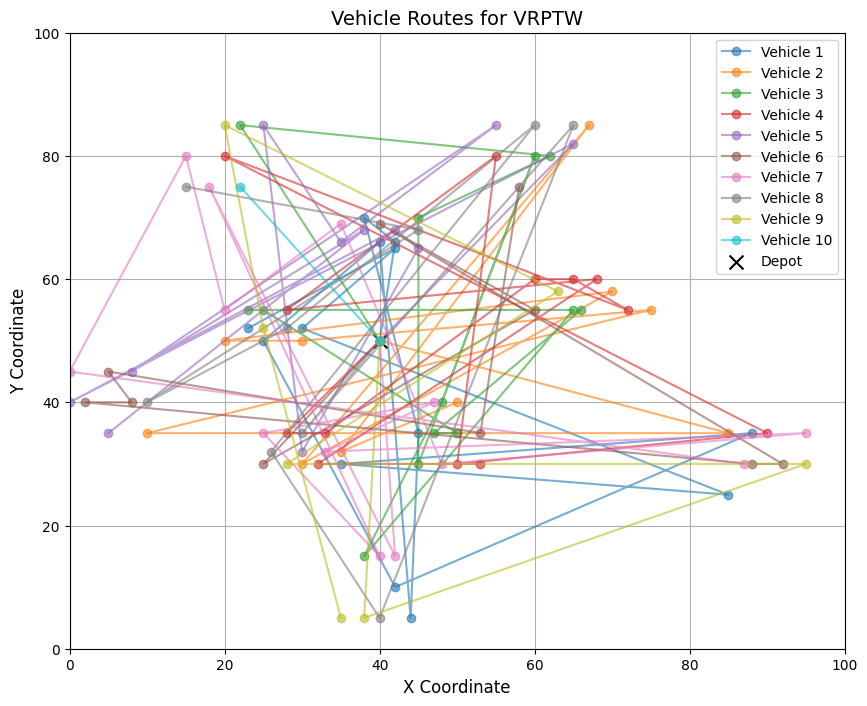

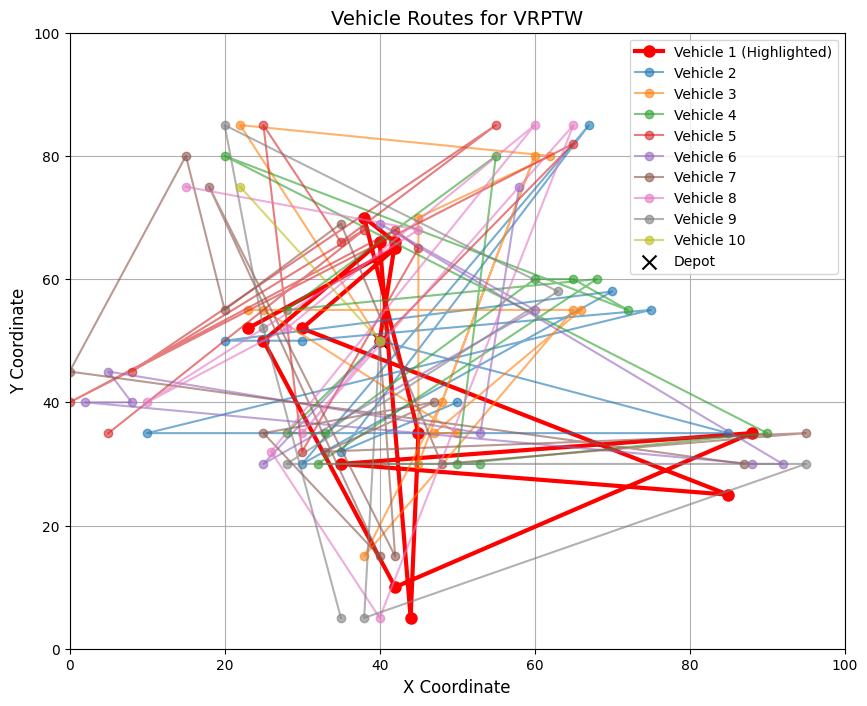

In [33]:
aco.visualize_routes()
aco.visualize_routes(highlight_vehicle=0) 